# Polynomial Linear Regression

To get started, we look at a simple linear regression example with `cofi`.

We assume a linear problem, for which we know a dataset X, Y and a polynomial forward function with a degree of 3.

---
## 0. Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from cofi import BaseProblem, InversionOptions, InversionRunner

---
## 1. Define the problem

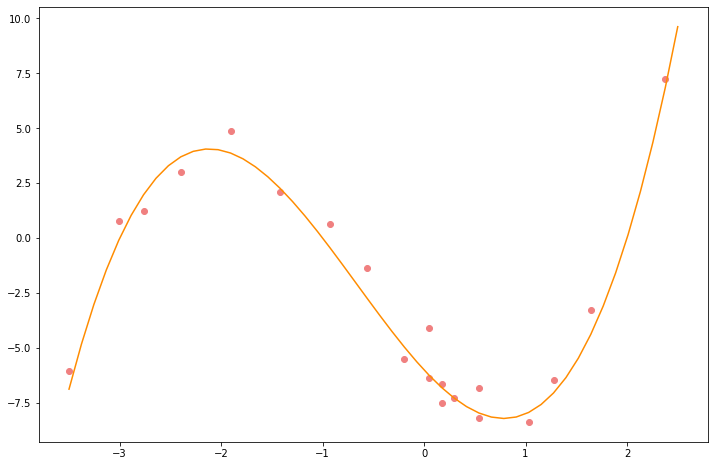

In [2]:
# generate data with random Gaussian noise
basis_func = lambda x: np.array([x**i for i in range(4)]).T               # x -> G
_m_true = np.array([-6,-5,2,1])                                           # m

sample_size = 20                                                          # N
x = np.random.choice(np.linspace(-3.5,2.5), size=sample_size)             # x
forward_func = lambda m: basis_func(x) @ m                                # m -> y_synthesis
y_observed = forward_func(_m_true) + np.random.normal(0,1,sample_size)    # d

############## PLOTTING ###############################################################
_x_plot = np.linspace(-3.5,2.5)
_G_plot = basis_func(_x_plot)
_y_plot = _G_plot @ _m_true
plt.figure(figsize=(12,8))
plt.plot(_x_plot, _y_plot, color="darkorange")
plt.scatter(x, y_observed, color="lightcoral")

In [3]:
# define the problem
inv_problem = BaseProblem()
inv_problem.set_dataset(x, y_observed)
inv_problem.set_forward(forward_func)
inv_problem.set_jacobian(basis_func(x))

inv_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: Unknown
------------------------------------------
List of functions / properties defined:
['residual', 'jacobian', 'forward', 'dataset']


---
## 2. Define the inversion

In [4]:
inv_options = InversionOptions()
inv_options.summary()

Summary for inversion options
Solving method: Not set yet
Backend tool: scipy.optimize.minimize (by default)
-----------------------------
Solver-specific parameters: Not set yet


In [5]:
inv_options.suggest_tools()

Here's a complete list of inversion solvers supported by CoFI (grouped by methods):
{
    "optimisation": [
        "scipy.optimize.minimize"
    ],
    "least square": [
        "numpy.linalg.lstsq"
    ]
}


In [6]:
inv_options.set_solving_method("least square")
inv_options.summary()

Summary for inversion options
Solving method: least square
Backend tool: numpy.linalg.lstsq (by default)
-----------------------------
Solver-specific parameters: Not set yet


---

As the "summary" suggested, you've set the solving method, so you can skip the step of
setting a backend tool because there's a default one.

If there are more backend tool options, then use the following function to see available
options and set your desired backend solver.

In [7]:
inv_options.suggest_tools()

Based on the solving method you've set, the following tools are suggested:
['numpy.linalg.lstsq']

Use `InversionOptions.set_tool(tool_name)` to set a specific tool from above
Use `InversionOptions.set_solving_method(tool_name)` to change solving method
Use `InversionOptions.unset_solving_method()` if you'd like to see more options
Check CoFI documentation 'Advanced Usage' section for how to plug in your own solver


In [14]:
inv_options.set_tool("numpy.linalg.lstsq")
inv_options.summary()

Summary for inversion options
Solving method: least square
Backend tool: numpy.linalg.lstsq
-----------------------------
Solver-specific parameters: Not set yet


---
## 3. Start an inversion runner

In [9]:
inv_runner = InversionRunner(inv_problem, inv_options)
inv_runner.summary()

Summary for inversion runner
Inversion hasn't started, try `runner.run()` to see result
---------------------------------------
With inversion solver defined as below:

Summary for inversion options
Solving method: least square
Backend tool: numpy.linalg.lstsq
Solver-specific parameters: Not set yet
---------------------------------------
For inversion problem defined as below:

Summary for inversion problem: BaseProblem
Model shape: Unknown
List of functions / properties defined:
['residual', 'jacobian', 'forward', 'dataset']


In [10]:
inv_result = inv_runner.run()
inv_result.ok

True

In [11]:
inv_result.summary()

Summary for inversion result
SUCCESS
----------------------------
model: [-5.65075328 -4.89920453  2.00071224  0.98958859]
residuals: [12.64333816]
rank: 4
singular_values: [61.61917544 11.11706045  3.33512846  3.04255617]


---
## 4. Check back your problem setting, inversion setting & result

In [13]:
inv_runner.summary()

Summary for inversion runner
Trained with the following result:

Summary for inversion result
SUCCESS
model: [-5.65075328 -4.89920453  2.00071224  0.98958859]
residuals: [12.64333816]
rank: 4
singular_values: [61.61917544 11.11706045  3.33512846  3.04255617]
---------------------------------------
With inversion solver defined as below:

Summary for inversion options
Solving method: least square
Backend tool: numpy.linalg.lstsq
Solver-specific parameters: Not set yet
---------------------------------------
For inversion problem defined as below:

Summary for inversion problem: BaseProblem
Model shape: Unknown
List of functions / properties defined:
['residual', 'jacobian', 'forward', 'dataset']


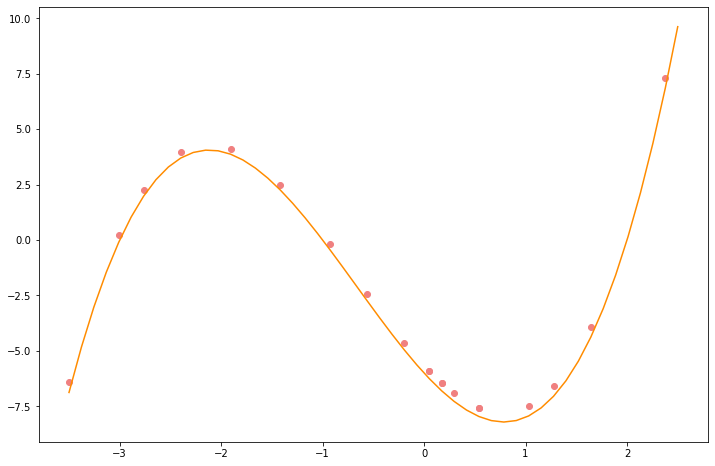

In [15]:
y_synthesis = inv_problem.forward(inv_result.model)

############## PLOTTING ###############################################################
_x_plot = np.linspace(-3.5,2.5)
_G_plot = basis_func(_x_plot)
_y_plot = _G_plot @ _m_true
plt.figure(figsize=(12,8))
plt.plot(_x_plot, _y_plot, color="darkorange")
plt.scatter(x, y_synthesis, color="lightcoral")

---